## Import thư viện 

In [1]:
import re
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

Đọc dữ liệu đầu vào

In [2]:
df1 = pd.read_csv('raw data/Big_DS.csv')  
df1 = df1.drop(columns=['names','link','tag']) 
df1 = df1.drop_duplicates()
df1 = df1.reset_index(drop=True)
df1.head(10)

,price,brand,type,condition,preserve,storage,result,display,camera,pin,date,ram_storage
0,6.000.000 đ,samsung,galaxy s21 fe,đã sử dụng (chưa sửa chữa),đang cập nhật,128.0 gb,0,"6.4""",12MP,4500mAh,"Released 2022, January 07","128GB 6GB RAM, 128GB 8GB RAM, 256GB 8GB RAM"
1,6.050.000 đ,apple,iphone 11,đã sử dụng (chưa sửa chữa),đang cập nhật,64 gb,1,"6.1""",12MP,3110mAh,"Released 2019, September 20","64GB 4GB RAM, 128GB 4GB RAM, 256GB 4GB RAM"
2,13.900.000 đ,apple,iphone 12 pro max,đã sử dụng (chưa sửa chữa),đang cập nhật,256 gb,1,"6.7""",12MP,3687mAh,"Released 2020, November 13","128GB 6GB RAM, 256GB 6GB RAM, 512GB 6GB RAM"
3,7200000,apple,iphone xs max,đã sử dụng (chưa sửa chữa),hết bảo hành,256.0 gb,0,"6.5""",12MP,3174mAh,"Released 2018, September 21","64GB 4GB RAM, 256GB 4GB RAM, 512GB 4GB RAM"
4,8.000.000 đ,apple,iphone 12,đã sử dụng (chưa sửa chữa),3 tháng,128.0 gb,1,"6.1""",12MP,2815mAh,"Released 2020, October 23","64GB 4GB RAM, 128GB 4GB RAM, 256GB 4GB RAM"
5,1.800.000 đ,apple,iphone x,đã sử dụng (qua sửa chữa),hết bảo hành,64 gb,0,"5.8""",12MP,2716mAh,"Released 2017, November 03","64GB 3GB RAM, 256GB 3GB RAM"
6,16600000,apple,iphone 13 pro max,đã sử dụng (chưa sửa chữa),còn bảo hành,256.0 gb,0,"6.7""",12MP,4352mAh,"Released 2021, September 24","128GB 6GB RAM, 256GB 6GB RAM, 512GB 6GB RAM, 1..."
7,2.700.000 đ,apple,iphone 7 plus,đã sử dụng (chưa sửa chữa),hết bảo hành,128 gb,0,"5.5""",12MP,2900mAh,"Released 2016, September 16","32GB 3GB RAM, 128GB 3GB RAM, 256GB 3GB RAM"
8,2.000.000 đ,apple,iphone xs max,đã sử dụng (qua sửa chữa),đang cập nhật,64.0 gb,0,"6.5""",12MP,3174mAh,"Released 2018, September 21","64GB 4GB RAM, 256GB 4GB RAM, 512GB 4GB RAM"
9,13.500.000 đ,apple,iphone 12 pro,đã sử dụng (chưa sửa chữa),đang cập nhật,128 gb,0,"6.7""",12MP,3687mAh,"Released 2020, November 13","128GB 6GB RAM, 256GB 6GB RAM, 512GB 6GB RAM"


### Các hàm xử lí dùng để làm sạch dữ liệu

Hàm tách ram_storage thành mảng gồm 2 phần tử là storage và ram

In [3]:
def split_ram_storage(value) : 
    if isinstance(value, str) : 
        pattern = r'\d+(?:GB|MB|TB)(?: \d+(?:\.\d+)?(?:GB|MB|TB))? RAM'
        value = re.findall(pattern, value)
    return value

Hàm chuyển đổi đơn vị MB và TB về GB

In [4]:
def convert_to_GB(value) : 
    if isinstance(value, str) : 
        value = re.sub(r'(\d+)MB', lambda m: str(int(m.group(1)) / 1024) + 'GB', value)
        value = re.sub(r'(\d+)TB', lambda m: str(int(m.group(1)) * 1024) + 'GB', value)
    return value

Hàm tách lấy số và bỏ đi đơn vị

In [5]:
def convert_ram_storage(value):
    # Tách lấy phần số đầu tiên và phần số thứ hai từ chuỗi
    # print(value)
    if isinstance(value, str) :
        matches = re.findall(r'(\d+\.?\d*)GB', value)
        if len(matches) == 2:
            return ' '.join(matches)
        else:
            return value

Hàm tách chỉ lấy phần số

In [6]:
def extract_number(value) : 
    if isinstance(value, str):
        pattern = r'\d+'
        numbers = re.findall(pattern, value)
        if numbers:
            return numbers[0]
    return None

Tạo dataframe mới lấy từ cột type và ram_storage để dễ xử lí chia tách ram và storage

In [7]:
df_chitiet = df1[['type','ram_storage']]
df_chitiet = df_chitiet.drop_duplicates() 
df_chitiet = df_chitiet.reset_index(drop=True) 

# bỏ những kí tự có dạng (...) 
df_chitiet['ram_storage'] = df_chitiet['ram_storage'].str.replace(r'\s\([^)]*\)', '')
df_chitiet['ram_storage'] = df_chitiet['ram_storage'].str.replace(',','')

# tách ram_storage thành mảng chứa các cặp ram-storage
df_chitiet['ram_storage'] = df_chitiet['ram_storage'].apply(split_ram_storage)

# tach hang co nhieu chi so ram thanh nhieu hang 
df_chitiet = df_chitiet.explode('ram_storage') 
df_chitiet = df_chitiet.reset_index(drop=True) 

# chuyen doi don vi ve GB 
df_chitiet['ram_storage'] = df_chitiet['ram_storage'].apply(convert_to_GB) 

# tach lay so
df_chitiet['ram_storage'] = df_chitiet['ram_storage'].apply(convert_ram_storage)

# tach ram va storage thanh 2 cot rieng
df_chitiet[['storage','ram']] = df_chitiet['ram_storage'].str.split(" ", n=1, expand=True)

# bo 2 cot date va ram_storage
df_chitiet = df_chitiet.drop('ram_storage',axis=1) 

df_chitiet['storage'] = df_chitiet['storage'].astype(float)
df_chitiet['ram'] = df_chitiet['ram'].astype(float)

print(df_chitiet)

# lọc những hàng có cùng storage và giữ lại hàng có ram cao nhất
df_chitiet_filtered = df_chitiet.copy()
df_chitiet_filtered = df_chitiet_filtered.loc[df_chitiet_filtered.groupby(['storage','type'])['ram'].idxmax()]
df_chitiet_filtered = pd.concat([df_chitiet_filtered, df_chitiet[df_chitiet['storage'].isnull()]])
print(df_chitiet_filtered.isnull().sum())

df_chitiet_filtered = df_chitiet_filtered.reset_index(drop=True)
print(df_chitiet_filtered)



                         type  storage  ram
0               galaxy s21 fe    128.0  6.0
1               galaxy s21 fe    128.0  8.0
2               galaxy s21 fe    256.0  8.0
3                   iphone 11     64.0  4.0
4                   iphone 11    128.0  4.0
..                        ...      ...  ...
505                galaxy a9s     64.0  8.0
506                galaxy a9s    128.0  6.0
507                galaxy a9s    128.0  8.0
508  galaxy grand prime g531h      8.0  1.0
509            galaxy grand 2      8.0  1.5

[510 rows x 3 columns]
type       0
storage    3
ram        3
dtype: int64
                         type  storage   ram
0                   galaxy j1      4.0  0.75
1              galaxy grand 2      8.0  1.50
2     galaxy grand prime g531      8.0  1.00
3    galaxy grand prime g531h      8.0  1.00
4                   galaxy j1      8.0  1.00
..                        ...      ...   ...
405             iphone 14 pro   1024.0  6.00
406         iphone 14 pro max   1024

C:\Users\HP\AppData\Local\Temp\ipykernel_20864\787555928.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_chitiet['ram_storage'] = df_chitiet['ram_storage'].str.replace(r'\s\([^)]*\)', '')


In [8]:
print(df1.isnull().sum())

price            0
brand            0
type             0
condition        0
preserve         0
storage        236
result           0
display         26
camera          26
pin             26
date            26
ram_storage     26
dtype: int64


Merge dataframe ở bước trước vào dataframe ban đầu, lúc này dataframe ban đầu sẽ có thêm cột storage và ram

In [9]:
# lấy phần số ở cột storage
df1['storage'] = df1['storage'].apply(extract_number) 
df1['storage'] = df1['storage'].astype(float) 


In [10]:
df1['type'] = df1['type'].str.lower() 
df_chitiet_filtered['type'] = df_chitiet_filtered['type'].str.lower() 
df_merged = df1.merge(df_chitiet_filtered,on=['type','storage'],how='left') 
df_merged = df_merged.drop(columns='ram_storage')
df_merged = df_merged.reset_index(drop=True) 

print(df_merged)


             price    brand                  type                   condition  \
0      6.000.000 đ  samsung         galaxy s21 fe  đã sử dụng (chưa sửa chữa)   
1      6.050.000 đ    apple             iphone 11  đã sử dụng (chưa sửa chữa)   
2     13.900.000 đ    apple     iphone 12 pro max  đã sử dụng (chưa sửa chữa)   
3          7200000    apple         iphone xs max  đã sử dụng (chưa sửa chữa)   
4      8.000.000 đ    apple             iphone 12  đã sử dụng (chưa sửa chữa)   
...            ...      ...                   ...                         ...   
9452      13550000  samsung        galaxy z fold3  đã sử dụng (chưa sửa chữa)   
9453  10.500.000 đ    apple         iphone 12 pro  đã sử dụng (chưa sửa chữa)   
9454   4.000.000 đ  samsung  galaxy note 20 ultra  đã sử dụng (chưa sửa chữa)   
9455   9.000.000 đ    apple        iphone 13 mini  đã sử dụng (chưa sửa chữa)   
9456   4.600.000 đ    apple             iphone xs  đã sử dụng (chưa sửa chữa)   

           preserve  storag

Format lại dataframe bao gồm mã hóa các giá trị string về giá trị 0 và 1, lấy các chi tiết cần thiết để tạo đặc trưng và bỏ các chi tiết không cần thiết

In [11]:
def DS_formatting(df) : 
    # year 
    df['year'] = df['date'].str.extract(r'Released (\d{4})')
    df['year'] = df['year'].astype(float)
    df = df.drop(columns='date')
    # brand
    df['brand'] = df['brand'].replace('apple',1) 
    df['brand'] = df['brand'].replace('samsung',0)
    df['brand'] = df['brand'].astype(int)
    # condition
    df['condition'] = df['condition'].replace('đã sử dụng (chưa sửa chữa)',1) 
    df['condition'] = df['condition'].replace('đã sử dụng (qua sửa chữa)',0)
    df['condition'] = df['condition'].astype(int)

    # preserve 
    df['preserve'] = df['preserve'].replace(["đang cập nhật","hết bảo hành","0"],0)
    df['preserve'] = df['preserve'].replace(["còn bảo hành","3 tháng", "4-6 tháng", "1 tháng", "7-12 tháng", ">12 tháng", "2 tháng", "1"], 1)
    df['preserve'] = df['preserve'].astype(int)

    # price
    df['price'] = df['price'].str.replace('[đ\.]','',regex=True) 
    df['price'] = df['price'].astype(float) 

    # camera
    df['camera'] = df['camera'].str.replace("MP","")
    df['camera'] = df['camera'].astype(float) 

    # display
    df['display'] = df['display'].str.replace('"','')
    df['display'] = df['display'].astype(float) 

    # pin 
    df['pin'] = df['pin'].str.replace('mAh','')
    df['pin'] = df['pin'].astype(float) 
    
    return df

In [12]:
df_bigDS = DS_formatting(df_merged)
print(df_bigDS)

           price  brand                  type  condition  preserve  storage  \
0      6000000.0      0         galaxy s21 fe          1         0    128.0   
1      6050000.0      1             iphone 11          1         0     64.0   
2     13900000.0      1     iphone 12 pro max          1         0    256.0   
3      7200000.0      1         iphone xs max          1         0    256.0   
4      8000000.0      1             iphone 12          1         1    128.0   
...          ...    ...                   ...        ...       ...      ...   
9452  13550000.0      0        galaxy z fold3          1         0    256.0   
9453  10500000.0      1         iphone 12 pro          1         0    128.0   
9454   4000000.0      0  galaxy note 20 ultra          1         1    256.0   
9455   9000000.0      1        iphone 13 mini          1         0    128.0   
9456   4600000.0      1             iphone xs          1         0    256.0   

      result  display  camera     pin   ram    year

In [13]:
df_bigDS.head(10)

,price,brand,type,condition,preserve,storage,result,display,camera,pin,ram,year
0,6000000.0,0,galaxy s21 fe,1,0,128.0,0,6.4,12.0,4500.0,8.0,2022.0
1,6050000.0,1,iphone 11,1,0,64.0,1,6.1,12.0,3110.0,4.0,2019.0
2,13900000.0,1,iphone 12 pro max,1,0,256.0,1,6.7,12.0,3687.0,6.0,2020.0
3,7200000.0,1,iphone xs max,1,0,256.0,0,6.5,12.0,3174.0,4.0,2018.0
4,8000000.0,1,iphone 12,1,1,128.0,1,6.1,12.0,2815.0,4.0,2020.0
5,1800000.0,1,iphone x,0,0,64.0,0,5.8,12.0,2716.0,3.0,2017.0
6,16600000.0,1,iphone 13 pro max,1,1,256.0,0,6.7,12.0,4352.0,6.0,2021.0
7,2700000.0,1,iphone 7 plus,1,0,128.0,0,5.5,12.0,2900.0,3.0,2016.0
8,2000000.0,1,iphone xs max,0,0,64.0,0,6.5,12.0,3174.0,4.0,2018.0
9,13500000.0,1,iphone 12 pro,1,0,128.0,0,6.7,12.0,3687.0,6.0,2020.0


Xuất ra dữ liệu đã được làm sạch

In [14]:
df_bigDS.to_csv('clean data/bigDS_clean.csv',index=False)

### Xử lý null

Sử dụng phương pháp xử lí dữ liệu trống bằng các thay thế giá trị random của cột tương ứng

In [15]:
df_bigDS[df_bigDS.isnull().any(axis=1)].head(10)

,price,brand,type,condition,preserve,storage,result,display,camera,pin,ram,year
19,16500000.0,1,iphone 12 pro max,1,0,NaN,0,6.7,12.0,3687.0,NaN,2020.0
39,4500000.0,0,galaxy s8,1,1,128.0,0,5.8,12.0,3000.0,NaN,2017.0
48,450000.0,1,iphone 5s,1,0,NaN,0,4.0,8.0,1560.0,NaN,2013.0
56,18599000.0,1,iphone 13 pro max,1,0,NaN,0,6.7,12.0,4352.0,NaN,2021.0
68,900000.0,1,iphone 6s plus,0,0,NaN,0,5.5,12.0,2750.0,NaN,2015.0
69,950000.0,0,galaxy s10 plus,1,0,256.0,0,6.1,16.0,3400.0,NaN,2019.0
75,650000.0,0,galaxy j4 core,1,0,64.0,0,6.0,8.0,3300.0,NaN,2018.0
79,7500000.0,1,iphone 11,1,0,NaN,0,6.1,12.0,3110.0,NaN,2019.0
102,13000000.0,1,iphone 14 plus,1,0,NaN,0,6.7,12.0,4323.0,NaN,2022.0
114,3500000.0,0,galaxy note 10,1,0,128.0,0,6.8,12.0,4300.0,NaN,2019.0


In [16]:
print(df_bigDS.isnull().sum())

price          0
brand          0
type           0
condition      0
preserve       0
storage      236
result         0
display       26
camera        26
pin           26
ram          588
year          37
dtype: int64


Hàm fill giá trị null cho các cột

In [17]:
def fill_null_random(df, column) : 
    random_samples = df[column].dropna().sample(n=df[column].isnull().sum(), random_state=42) 
    random_samples.index = df[df[column].isnull()].index
    new_column = f"{column}_random"
    df[new_column] = df[column] 
    df.loc[df[column].isnull(),new_column] = random_samples
    df[column] = df[new_column] 
    df.drop(new_column,axis=1,inplace=True) 
    # print(df)
    return df


Tiến hành xử lí dữ liệu trống

In [18]:
df_bigDS_test = df_bigDS.copy() 
df_bigDS_test = fill_null_random(df_bigDS_test,'storage')
df_bigDS_test = fill_null_random(df_bigDS_test,'display') 
df_bigDS_test = fill_null_random(df_bigDS_test,'camera') 
df_bigDS_test = fill_null_random(df_bigDS_test,'pin') 
df_bigDS_test = fill_null_random(df_bigDS_test,'year') 
df_bigDS_test = fill_null_random(df_bigDS_test,'ram') 

df_bigDS_test.head(10)


,price,brand,type,condition,preserve,storage,result,display,camera,pin,ram,year
0,6000000.0,0,galaxy s21 fe,1,0,128.0,0,6.4,12.0,4500.0,8.0,2022.0
1,6050000.0,1,iphone 11,1,0,64.0,1,6.1,12.0,3110.0,4.0,2019.0
2,13900000.0,1,iphone 12 pro max,1,0,256.0,1,6.7,12.0,3687.0,6.0,2020.0
3,7200000.0,1,iphone xs max,1,0,256.0,0,6.5,12.0,3174.0,4.0,2018.0
4,8000000.0,1,iphone 12,1,1,128.0,1,6.1,12.0,2815.0,4.0,2020.0
5,1800000.0,1,iphone x,0,0,64.0,0,5.8,12.0,2716.0,3.0,2017.0
6,16600000.0,1,iphone 13 pro max,1,1,256.0,0,6.7,12.0,4352.0,6.0,2021.0
7,2700000.0,1,iphone 7 plus,1,0,128.0,0,5.5,12.0,2900.0,3.0,2016.0
8,2000000.0,1,iphone xs max,0,0,64.0,0,6.5,12.0,3174.0,4.0,2018.0
9,13500000.0,1,iphone 12 pro,1,0,128.0,0,6.7,12.0,3687.0,6.0,2020.0


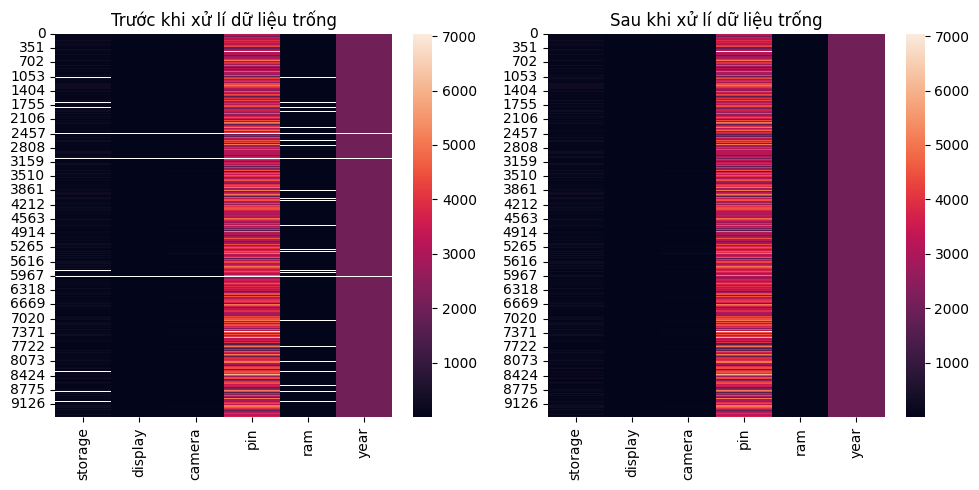

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(df_bigDS[['storage','display','camera','pin','ram','year']],ax=axes[0])
sns.heatmap(df_bigDS_test[['storage','display','camera','pin','ram','year']],ax=axes[1])
axes[0].set_title('Trước khi xử lí dữ liệu trống') 
axes[1].set_title('Sau khi xử lí dữ liệu trống') 
plt.tight_layout()
plt.show()

Xuất ra dữ liệu sau khi đã xử lí trống

In [20]:
df_bigDS_test.to_csv('bigDS_fillnull.csv',index=False) 

## Xử lý outlier

Kiểm tra phân phối của các đặc trưng trước khi xử lí ngoại lệ

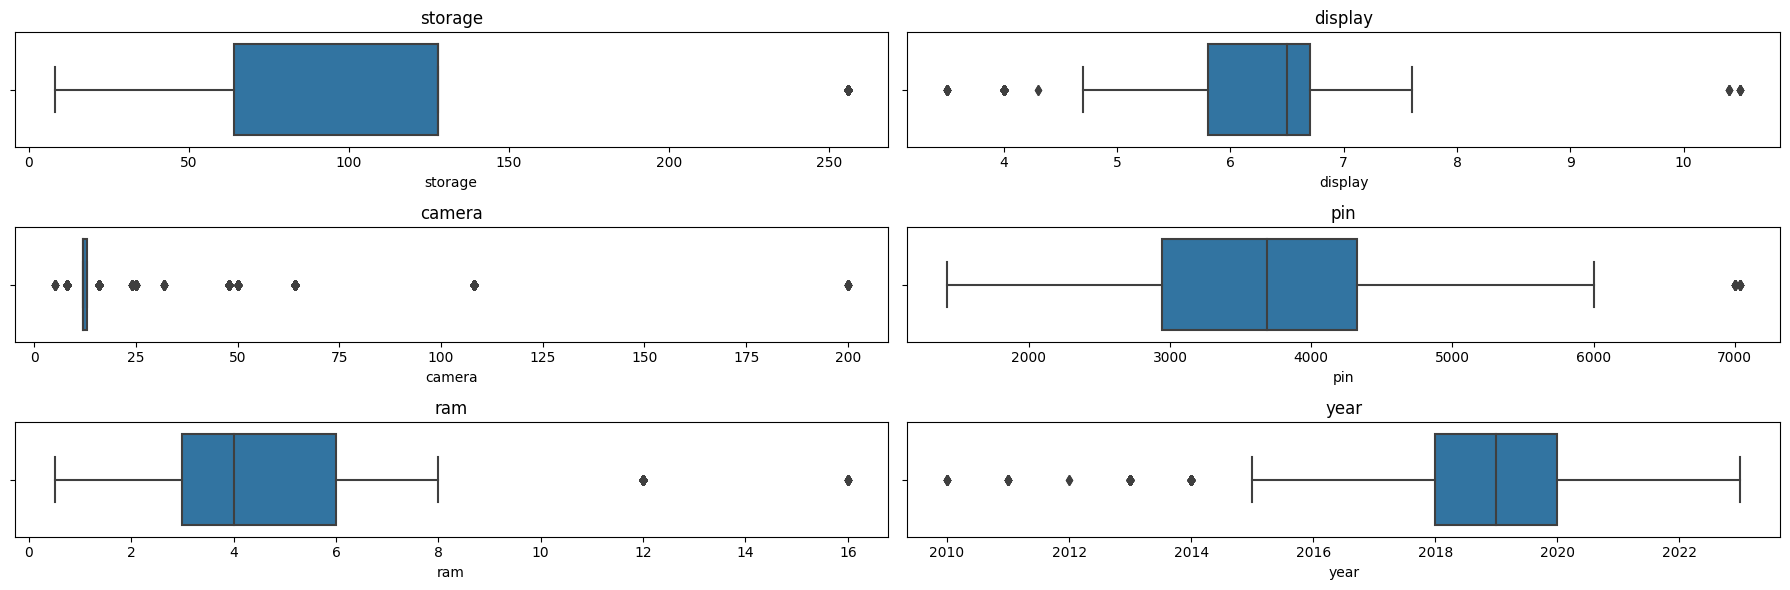

In [21]:
columns_names = ['storage','display','camera','pin','ram','year'] 
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(18,6)) 
for i, column in enumerate(columns_names) : 
    row = i//2
    col = i%2
    ax = axes[row, col] 
    sns.boxplot(x=df_bigDS_test[column],ax=ax) 
    ax.set_title(column) 

plt.tight_layout() 
plt.show()

Sử dụng kĩ thuật xử lí ngoại lệ Skewed

In [22]:
def skewed_outlier_handler(df, column) : 
    q25, q75 = np.percentile(df[column], [25,75]) 
    IQR = q75 - q25
    upper = q75 + 1.5*IQR
    lower = q25 - 1.5*IQR
    df.loc[df[column]>=upper,column] = upper 
    df.loc[df[column]<=lower,column] = lower
    return df

In [23]:
df_bigDS_test = skewed_outlier_handler(df_bigDS_test,'storage') 
df_bigDS_test = skewed_outlier_handler(df_bigDS_test,'display') 
df_bigDS_test = skewed_outlier_handler(df_bigDS_test,'camera') 
df_bigDS_test = skewed_outlier_handler(df_bigDS_test,'pin') 
df_bigDS_test = skewed_outlier_handler(df_bigDS_test,'ram') 
df_bigDS_test = skewed_outlier_handler(df_bigDS_test, 'year')

Phân phối dữ liệu của các đặc trưng sau khi xử lí ngoại lệ

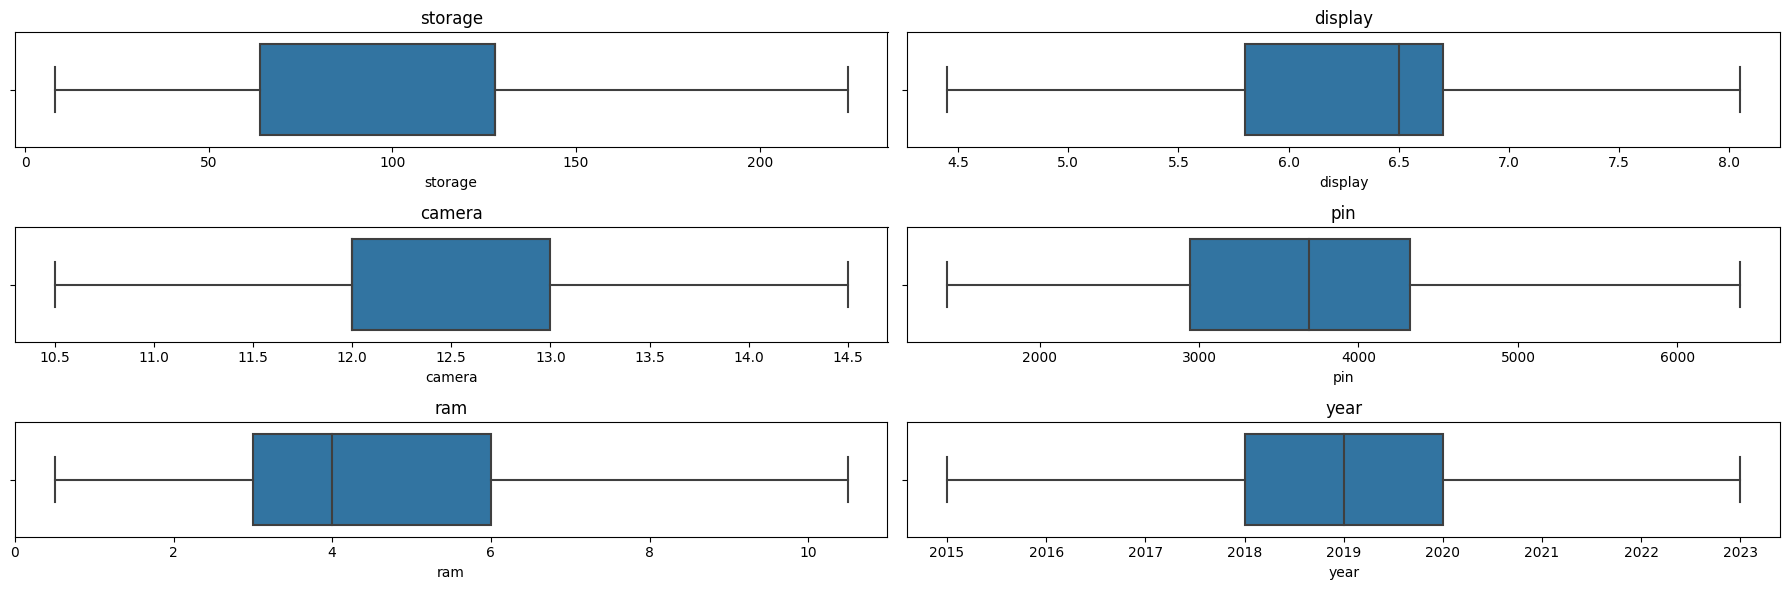

In [24]:
columns_names = ['storage','display','camera','pin','ram','year'] 
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(18,6)) 
for i, column in enumerate(columns_names) : 
    row = i//2
    col = i%2
    ax = axes[row, col] 
    sns.boxplot(x=df_bigDS_test[column],ax=ax) 
    ax.set_title(column) 

plt.tight_layout() 
plt.show()

Xuất ra dữ liệu sau khi đã xử lí ngoại lệ

In [25]:
df_bigDS_test.to_csv('bigDS_outlier.csv',index=False)

## Chuẩn hóa đặc trưng

Đồ thị xác suất trước khi chuẩn hóa

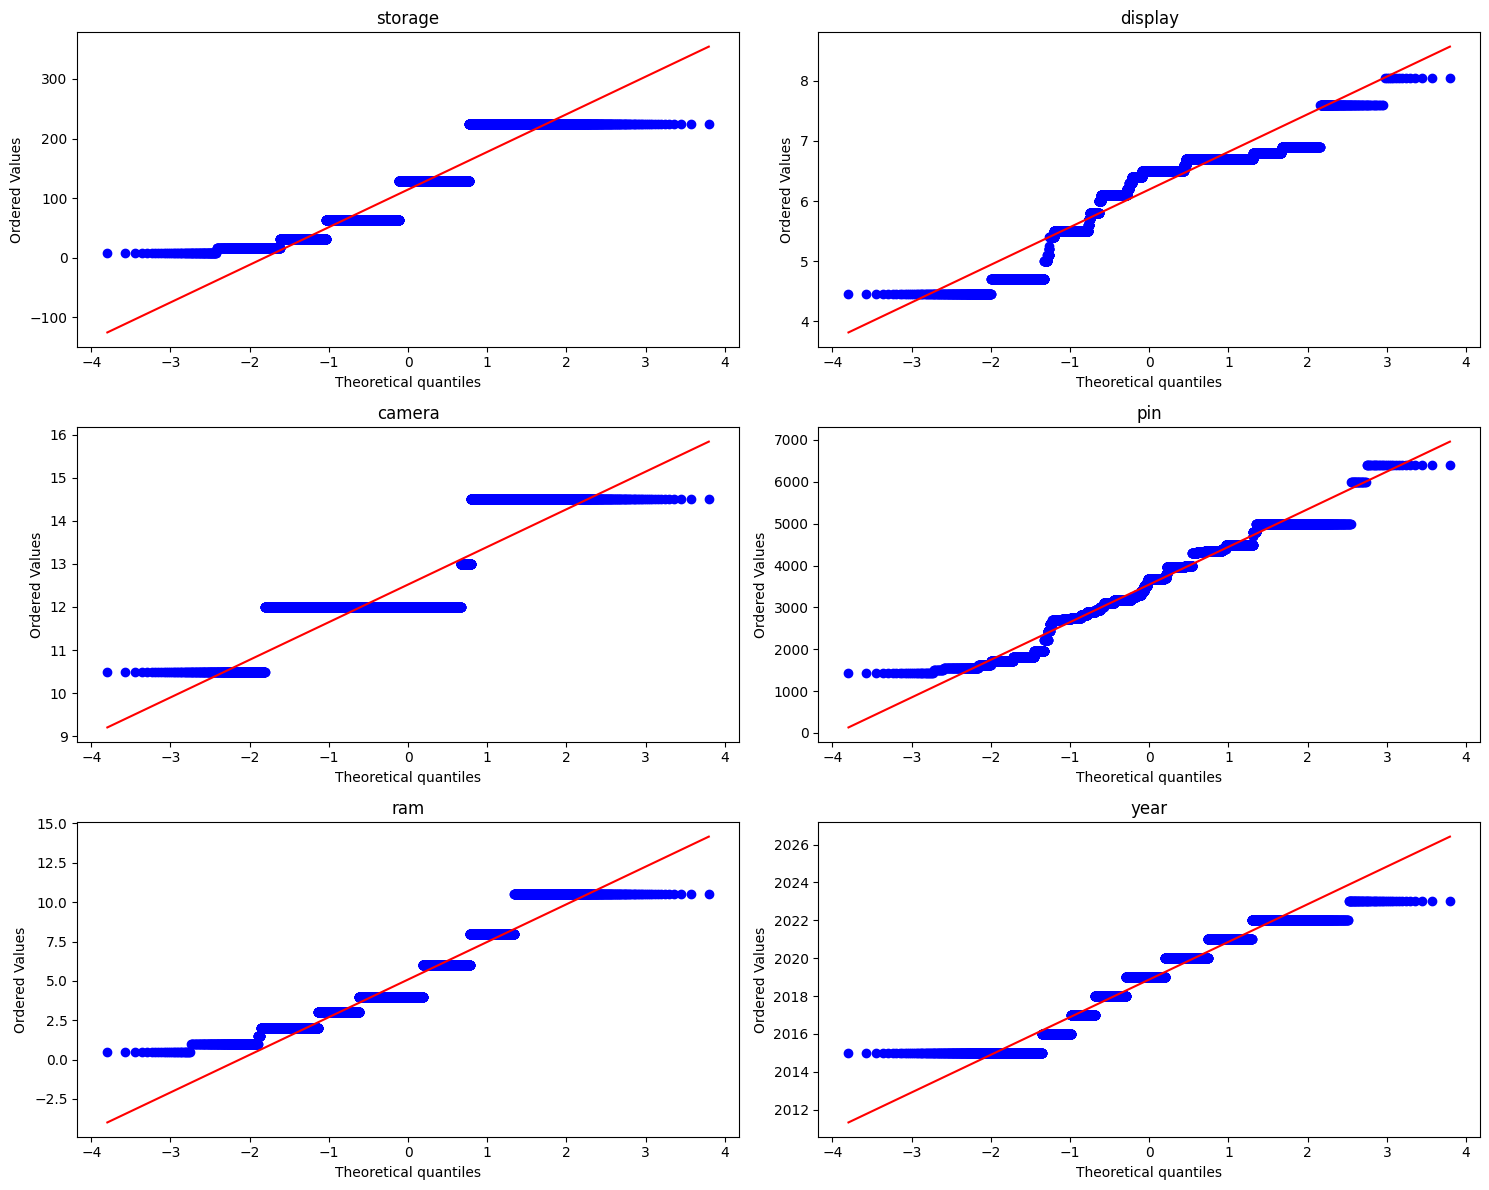

In [26]:
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(15,12)) 
for i, column in enumerate(columns_names) : 
    row = i//2
    col = i%2
    ax = axes[row, col] 
    stats.probplot(df_bigDS_test[column],dist='norm',plot=ax) 
    ax.set_title(column) 

plt.tight_layout() 
plt.show()

Tiến hành chuẩn hóa đặc trưng sử dụng Normalizer scaler

In [27]:
df_bigDS_normalizer = df_bigDS_test.copy()
df_bigDS_normalizer[['storage','display','camera','pin','ram']] = Normalizer().fit_transform(df_bigDS_normalizer[['storage','display','camera','pin','ram']])
print(df_bigDS_normalizer)

           price  brand                  type  condition  preserve   storage  \
0      6000000.0      0         galaxy s21 fe          1         0  0.028433   
1      6050000.0      1             iphone 11          1         0  0.020574   
2     13900000.0      1     iphone 12 pro max          1         0  0.060642   
3      7200000.0      1         iphone xs max          1         0  0.070398   
4      8000000.0      1             iphone 12          1         1  0.045423   
...          ...    ...                   ...        ...       ...       ...   
9452  13550000.0      0        galaxy z fold3          1         0  0.050843   
9453  10500000.0      1         iphone 12 pro          1         0  0.034695   
9454   4000000.0      0  galaxy note 20 ultra          1         1  0.049716   
9455   9000000.0      1        iphone 13 mini          1         0  0.052429   
9456   4600000.0      1             iphone xs          1         0  0.070398   

      result   display    camera       

Đồ thị xác suất sau khi đã chuẩn hóa đặc trưng

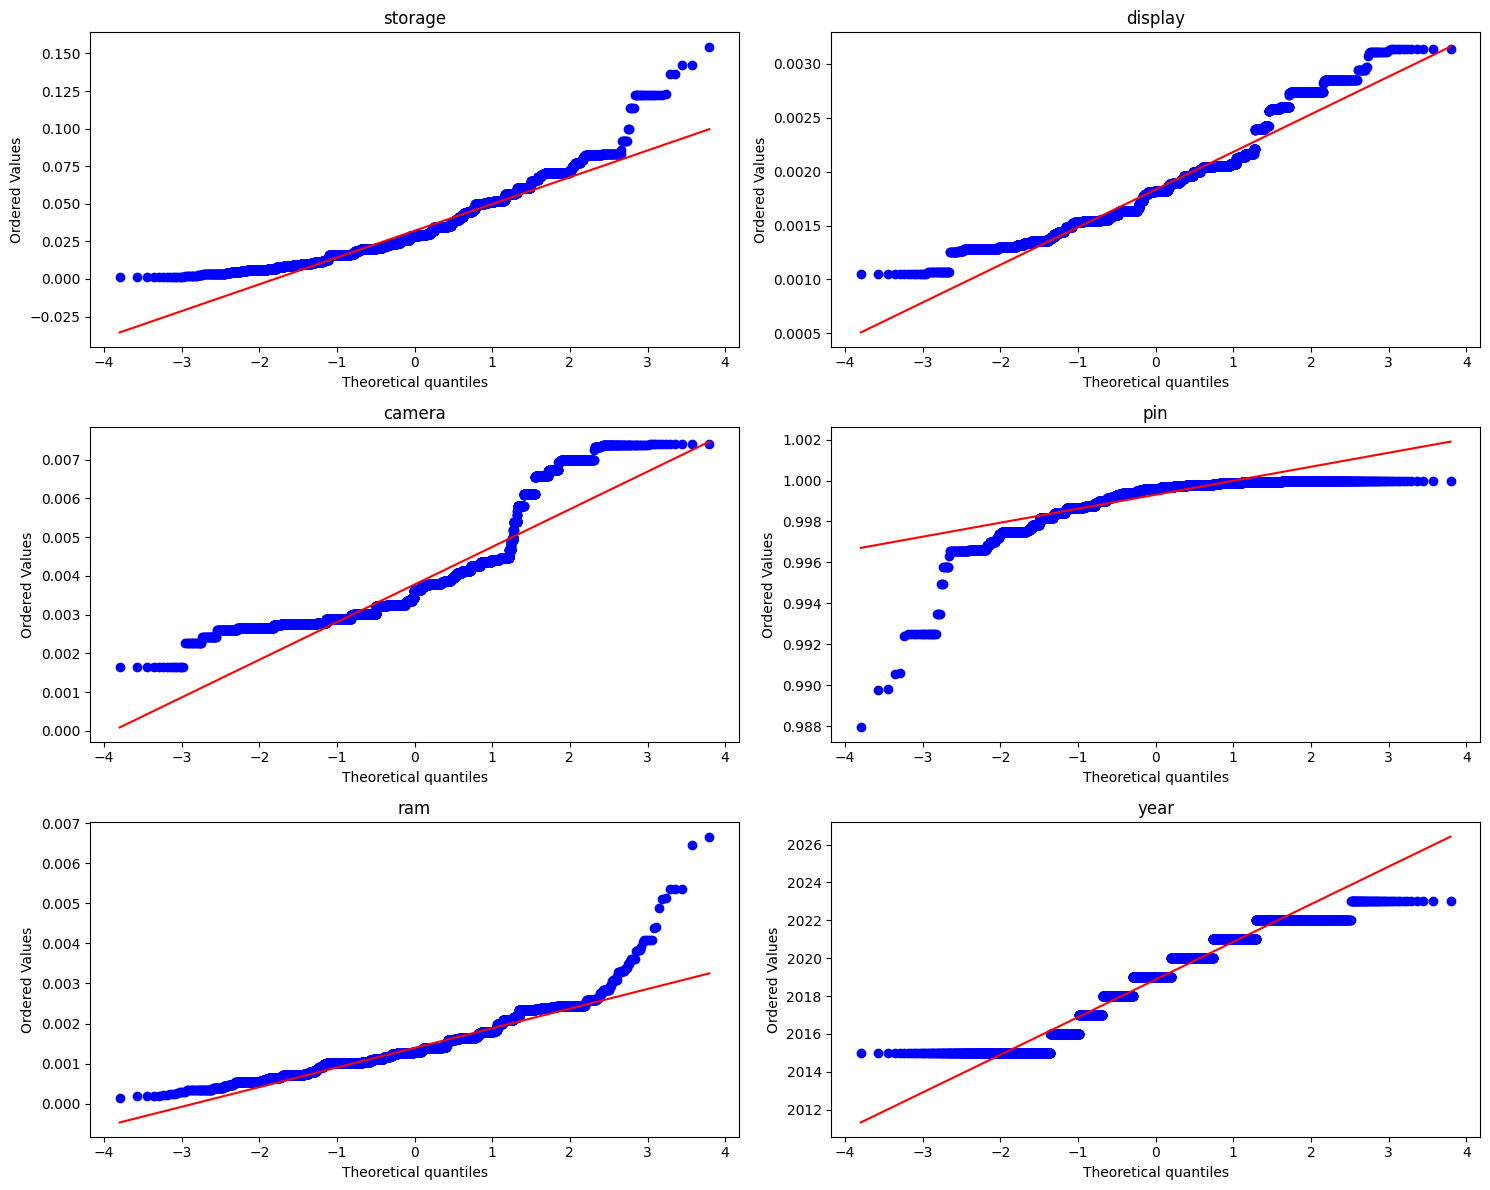

In [28]:
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(15,12)) 
for i, column in enumerate(columns_names) : 
    row = i//2
    col = i%2
    ax = axes[row, col] 
    stats.probplot(df_bigDS_normalizer[column],dist='norm',plot=ax) 
    ax.set_title(column) 

plt.tight_layout() 
plt.show()

Xuất ra dữ liệu sau khi đã chuẩn hóa

In [29]:
df_bigDS_normalizer.to_csv('bigDS_normalizer.csv',index=False)

In [30]:
print(df_bigDS_normalizer)

           price  brand                  type  condition  preserve   storage  \
0      6000000.0      0         galaxy s21 fe          1         0  0.028433   
1      6050000.0      1             iphone 11          1         0  0.020574   
2     13900000.0      1     iphone 12 pro max          1         0  0.060642   
3      7200000.0      1         iphone xs max          1         0  0.070398   
4      8000000.0      1             iphone 12          1         1  0.045423   
...          ...    ...                   ...        ...       ...       ...   
9452  13550000.0      0        galaxy z fold3          1         0  0.050843   
9453  10500000.0      1         iphone 12 pro          1         0  0.034695   
9454   4000000.0      0  galaxy note 20 ultra          1         1  0.049716   
9455   9000000.0      1        iphone 13 mini          1         0  0.052429   
9456   4600000.0      1             iphone xs          1         0  0.070398   

      result   display    camera       

## Lựa chọn đặc trưng

In [31]:
# Tính ma trận tự tương quan
correlation_matrix = df_bigDS_normalizer.corr()

# Đặt ngưỡng tương quan
threshold = 0.2

# Lựa chọn đặc trưng
selected_features = []
for feature in correlation_matrix:
    if feature == 'price':
        continue
    if abs(correlation_matrix['price'][feature]) > threshold:
        selected_features.append(feature)

# In ra các đặc trưng được lựa chọn
print(selected_features)

['brand', 'preserve', 'storage', 'display', 'camera', 'ram', 'year']


C:\Users\HP\AppData\Local\Temp\ipykernel_20864\3727975460.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_bigDS_normalizer.corr()


Xuất ra dữ liệu với các đặc trưng được chọn

In [32]:
df_bigDS_normalizer.to_csv('bigDS_FTselection.csv',columns=['price']+selected_features, index=False) 

Heatmap ma trận tương quan giữa các đặc trưng

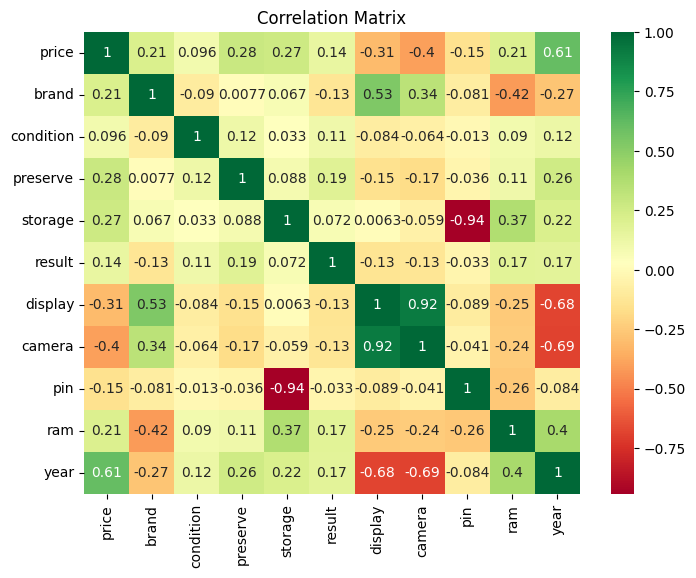

In [33]:
plt.figure(figsize=(8,6)) 
# first_row_df = pd.DataFrame(correlation_matrix.iloc[0]).T
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn') 
plt.title('Correlation Matrix') 
plt.show() 